<a href="https://colab.research.google.com/github/halah1998/Dysarthria-Classifier/blob/main/k_NN_Classification_(all_datasets_median_remove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from os import system
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where, random
!pip install scikit-multilearn

In [269]:
data = pd.read_csv('all_disorders_median_std.csv')
data2=pd.read_csv('all_disorders_remove_std.csv')

In [270]:
def smote_multiclass(df, num_samples_dict=None, one_hot_encoded=False):
  """
  Performs data augmentation and/or downsampling on a dataframe with multiple classes.
  Supports both numerical and one-hot encoded class values.
  The SMOTE algorithm is used for augmentation and random sampling is used for downsampling of the specified classes.
  Keyword arguments:
  df -- the dataframe to manipulate
  num_samples_dict -- a dictionary of the form {0: num_desired_samples, 1: num_desired_samples, ...} that indicates the
                      number of samples that the returned dataframe should have in each class
  one_hot_encoded -- Boolean value indicating if the dataframe is one-hot encoded
  """

  if df.columns[[0]] == 'Unnamed: 0':
    df.drop(df.columns[[0]], axis=1, inplace=True)  # remove first column

  # change one hot encoded dataset into numerical labels
  if one_hot_encoded:
    df.insert(loc=0, column='Status', value=np.nan)
    for i, row in df.iterrows():
      if df.iloc[i]['Control'] == 1:
          status = 0
      elif df.iloc[i]['Parkinsons'] == 1:
          status = 1
      elif df.iloc[i]['ALS'] == 1:
          status = 2
      elif df.iloc[i]['Cerebral_palsy'] == 1:
          status = 3
      df.at[i,'Status'] = status
    df = df.drop(columns=['Control', 'Parkinsons', 'ALS', 'Cerebral_palsy'])


  if num_samples_dict is not None:
    strategy = num_samples_dict

    # downsampling classes if needed
    counter = Counter(df.Status)
    class_samples = []
    for i in range(4):
      if counter[i] > num_samples_dict[i]: # class i needs to be downsampled
        class_i = df.loc[df['Status'] == i]
        class_i_sample = class_i.sample(n=num_samples_dict[i])
        class_samples.append(class_i_sample)
      else: # class i does not need downsampling
        class_i = df.loc[df['Status'] == i]
        class_samples.append(class_i)

    df = pd.concat(class_samples).reset_index(drop=True)

  else:
    strategy = 'auto'

  y = df.Status # labels
  x = df.drop(['Status', 'Gender'], axis=1) # features only, Gender also removed because it must be binary
  gender = df.Gender

  oversample = SMOTE(sampling_strategy=strategy)
  x_oversampled, y_oversampled = oversample.fit_resample(x, y)

  # get sample counts for augmented dataset
  counter = Counter(y_oversampled)

  if num_samples_dict is not None and (counter[0] != num_samples_dict[0] or counter[1] != num_samples_dict[1]
                                       or counter[2] != num_samples_dict[2] or counter[3] != num_samples_dict[3]):
    print("Sampling failed")
  elif num_samples_dict is None and (counter[0] != counter[1] or counter[1] != counter[2] or counter[2] != counter[3]):
    print("Sampling failed")

  # regenerate dataframe with new samples
  df_concat = pd.concat([pd.DataFrame(y_oversampled), pd.DataFrame(gender), pd.DataFrame(x_oversampled)], axis=1)
  df_concat.columns = df.columns

  # fill missing gender values with a random choice of 0 or 1
  for row in df_concat.loc[df_concat.Gender.isnull(), 'Gender'].index:
    df_concat.at[row, 'Gender'] = random.randint(0, 2)

  # change numerical class values back into one-hot encoded values
  if one_hot_encoded:
    one_hot = pd.get_dummies(df_concat['Status'])
    one_hot.rename(columns={0:'Control', 1:'Parkinsons', 2:'ALS', 3:'Cerebral_palsy'}, inplace=True)
    df_concat = df_concat.drop(columns=['Status'], axis=1)
    df_concat = pd.concat([one_hot, df_concat], axis=1)

  return df_concat, x, y

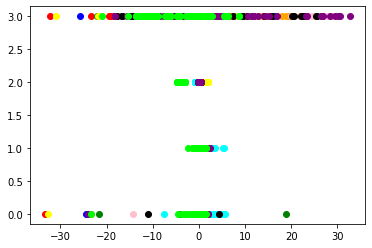

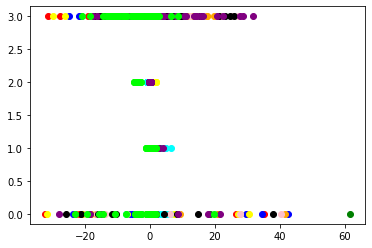

In [290]:
data, x, y = smote_multiclass(data, num_samples_dict={0: 200, 1: 180, 2: 150, 3:60},one_hot_encoded=False)
data2, x2, y2 = smote_multiclass(data2, num_samples_dict={0: 200, 1: 180, 2: 150, 3:60},one_hot_encoded=False)
#Visualizing data distribution for data 1
plt.scatter(x['MDVP:Jitter(%)'],y,color='red')
plt.scatter(x['MDVP:Jitter(Abs)'],y,color='green')
plt.scatter(x['Jitter:PPQ5'],y,color='blue')
plt.scatter(x['Jitter:DDP'],y,color='yellow')
plt.scatter(x['MDVP:Shimmer'],y,color='orange')
plt.scatter(x['MDVP:Shimmer(dB)'],y,color='cyan')
plt.scatter(x['Shimmer:APQ3'],y,color='pink')
plt.scatter(x['Shimmer:APQ5'],y,color='black')
plt.scatter(x['Shimmer:APQ11'],y,color='purple')
plt.scatter(x['DFA'],y,color='lime')
plt.show()

#Visualizing data distribution for data 2
plt.scatter(x2['MDVP:Jitter(%)'],y2,color='red')
plt.scatter(x2['MDVP:Jitter(Abs)'],y2,color='green')
plt.scatter(x2['Jitter:PPQ5'],y2,color='blue')
plt.scatter(x2['Jitter:DDP'],y2,color='yellow')
plt.scatter(x2['MDVP:Shimmer'],y2,color='orange')
plt.scatter(x2['MDVP:Shimmer(dB)'],y2,color='cyan')
plt.scatter(x2['Shimmer:APQ3'],y2,color='pink')
plt.scatter(x2['Shimmer:APQ5'],y2,color='black')
plt.scatter(x2['Shimmer:APQ11'],y2,color='purple')
plt.scatter(x2['DFA'],y2,color='lime')
plt.show()

In [272]:
'''Splitting Data for median dataset'''
# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_test, y_train,  y_test = train_test_split(x, y,train_size=0.7, test_size=0.3, random_state=42,stratify=y)
print(f"X_test length is {len(X_test)}.")
print(f"Y_test length is {len(y_test)}.")
print(f"X_train length is {len(X_train)}.")
print(f"Y_train length is {len(y_train)}.")

#Seeing the number/percentage of the split
s=np.unique(y_train, return_counts=True)
print()
print(f"The split is as follows:{s}")
print()

'''Splitting Data for remove dataset'''
# Splitting Data into 70% Training data and 30% Testing Data:
X_train2, X_test2, y_train2,  y_test2 = train_test_split(x2, y2,train_size=0.7, test_size=0.3, random_state=42,stratify=y2)
print(f"X_test2 length is {len(X_test2)}.")
print(f"Y_test2 length is {len(y_test2)}.")
print(f"X_train2 length is {len(X_train2)}.")
print(f"Y_train2 length is {len(y_train2)}.")

#Seeing the number/percentage of the split
s=np.unique(y_train2, return_counts=True)
print()
print(f"The split is as follows:{s}")

X_test length is 123.
Y_test length is 123.
X_train length is 285.
Y_train length is 285.

The split is as follows:(array([0, 1, 2, 3]), array([140, 126,  10,   9]))

X_test2 length is 123.
Y_test2 length is 123.
X_train2 length is 285.
Y_train2 length is 285.

The split is as follows:(array([0, 1, 2, 3]), array([140, 126,  10,   9]))


# K-Nearest Neighbor Classification

In [273]:
'''k-NN for Median Dataset'''
#k-NN
from sklearn.neighbors import KNeighborsClassifier
#To use the build in multilabel adabtor use:
#from skmultilearn.adapt import MLkNN
#knn_model= MLkNN(k=20)

#fiting training data on model
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn_model.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn_model.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn_model.score(X_test, y_test) 
    print(f"Train Accuracy:")
    print(train_accuracy[i])
    print(f"Test Accuracy:")
    print(test_accuracy[i])

#prediction using K-NN
y_pred = knn_model.predict(X_test)
print(f"The predictions for the data is {y_pred}")

#Looking at accuracy by counting the number of misclassified cases
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified))

#Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse1 = sqrt(mse)
print(f"Mean square error for training data is {rmse1}")

#evaluating the predictive performance of our model
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse2 = sqrt(mse)
print(f"Mean square error for test data is {rmse2}")

Train Accuracy:
1.0
Test Accuracy:
0.7642276422764228
Train Accuracy:
0.8771929824561403
Test Accuracy:
0.6910569105691057
Train Accuracy:
0.8526315789473684
Test Accuracy:
0.7235772357723578
Train Accuracy:
0.8210526315789474
Test Accuracy:
0.6585365853658537
Train Accuracy:
0.8
Test Accuracy:
0.6747967479674797
Train Accuracy:
0.7614035087719299
Test Accuracy:
0.6666666666666666
Train Accuracy:
0.7614035087719299
Test Accuracy:
0.6504065040650406
Train Accuracy:
0.7473684210526316
Test Accuracy:
0.6178861788617886
The predictions for the data is [0 1 0 0 0 0 0 0 0 0 2 0 1 0 1 1 1 0 1 0 0 2 1 0 0 0 0 0 2 0 2 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 2 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 3 0 0 0 1 1 0 0 0 2 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 2 0 0]
Misclassified samples in KNN: 47
Mean square error for training data is 0.6515837655350016
Mean square error for test data is 0.7597603387632995


In [274]:
'''k-NN for Remove Dataset'''
#k-NN
from sklearn.neighbors import KNeighborsClassifier
#To use the build in multilabel adabtor use:
#from skmultilearn.adapt import MLkNN
#knn_model= MLkNN(k=20)

#fiting training data on model
#Setup arrays to store training and test accuracies
neighbors2 = np.arange(1,9)
train_accuracy2 =np.empty(len(neighbors2))
test_accuracy2 = np.empty(len(neighbors2))

for i,K in enumerate(neighbors2):
    #Setup a knn classifier with k neighbors
    knn_model2 = KNeighborsClassifier(n_neighbors=K)
    
    #Fit the model
    knn_model2.fit(X_train2, y_train2)
    
    #Compute accuracy on the training set
    train_accuracy2[i] = knn_model2.score(X_train2, y_train2)
    
    #Compute accuracy on the test set
    test_accuracy2[i] = knn_model2.score(X_test2, y_test2) 
    print(f"Train Accuracy:")
    print(train_accuracy2[i])
    print(f"Test Accuracy:")
    print(test_accuracy2[i])

#prediction using K-NN
y_pred2 = knn_model2.predict(X_test2)
print(f"The predictions for the data is {y_pred2}")

#Looking at accuracy by counting the number of misclassified cases
count_misclassified2 = (y_test2 != y_pred2).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified2))

#Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds2 = knn_model2.predict(X_train2)
mse2 = mean_squared_error(y_train2, train_preds2)
rmse_a = sqrt(mse2)
print(f"Mean square error for training data is {rmse_a}")

#evaluating the predictive performance of our model
test_preds2 = knn_model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, test_preds2)
rmse_b = sqrt(mse2)
print(f"Mean square error for test data is {rmse_b}")

Train Accuracy:
1.0
Test Accuracy:
0.7560975609756098
Train Accuracy:
0.8175438596491228
Test Accuracy:
0.6585365853658537
Train Accuracy:
0.8280701754385965
Test Accuracy:
0.6504065040650406
Train Accuracy:
0.7403508771929824
Test Accuracy:
0.6829268292682927
Train Accuracy:
0.775438596491228
Test Accuracy:
0.6504065040650406
Train Accuracy:
0.7368421052631579
Test Accuracy:
0.7073170731707317
Train Accuracy:
0.7684210526315789
Test Accuracy:
0.6585365853658537
Train Accuracy:
0.7192982456140351
Test Accuracy:
0.6747967479674797
The predictions for the data is [0 0 0 1 0 1 0 1 0 0 2 0 1 0 0 2 0 1 1 0 0 2 0 0 2 0 0 0 2 0 2 1 0 0 0 1 0
 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 2 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 3 1 0 0 0 1 1 0 0 0 3 0 1 1 0 0 0 0 0 2 0 2
 0 1 0 0 0 1 0 0 1 2 1 0]
Misclassified samples in KNN: 40
Mean square error for training data is 0.6675432833065728
Mean square error for test data is 0.7860573635949152


# Parameter Tuning & Model Evaluation

In [275]:
'''K prediction for Median Dataset'''

#Predicting the best value of k 
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

#using .best_params_ to find the best performing k
print(f"The best value for k is {gridsearch.best_params_}")

#Seeing how this predicted k affects the training and testing performances
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
train_rmse

print(f"Mean square error for test data is {test_rmse}")

The best value for k is {'n_neighbors': 1}
Mean square error for test data is 0.6246950475544243


In [276]:
'''K prediction for Remove Dataset'''

#Predicting the best value of k 
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train2, y_train2)

#using .best_params_ to find the best performing k
print(f"The best value for k is {gridsearch.best_params_}")

#Seeing how this predicted k affects the training and testing performances
train_preds_grid2 = gridsearch.predict(X_train2)
train_mse2 = mean_squared_error(y_train2, train_preds_grid2)
train_rmse2 = sqrt(train_mse2)
test_preds_grid2 = gridsearch.predict(X_valid2)
test_mse2 = mean_squared_error(y_valid2, test_preds_grid2)
test_rmse2 = sqrt(test_mse2)
train_rmse2

print(f"Mean square error for test data is {test_rmse2}")

The best value for k is {'n_neighbors': 1}
Mean square error for test data is 0.5374838498865699


Text(0, 0.5, 'Mean Error')

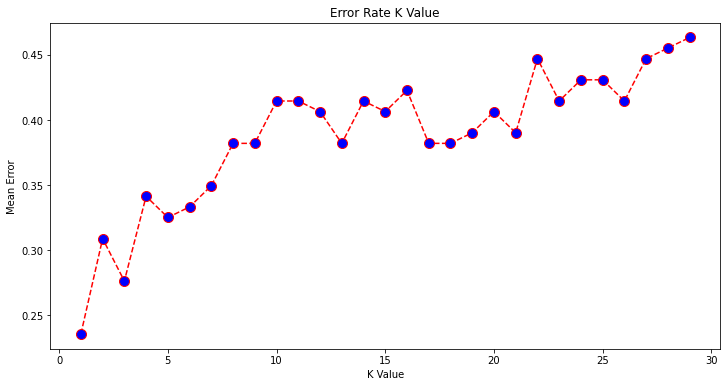

In [277]:
error = []

# Calculating error for K values between 1 and 40 for MEDIAN DATASET
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
# plot the error values against K values using the elbow graph method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Text(0, 0.5, 'Mean Error')

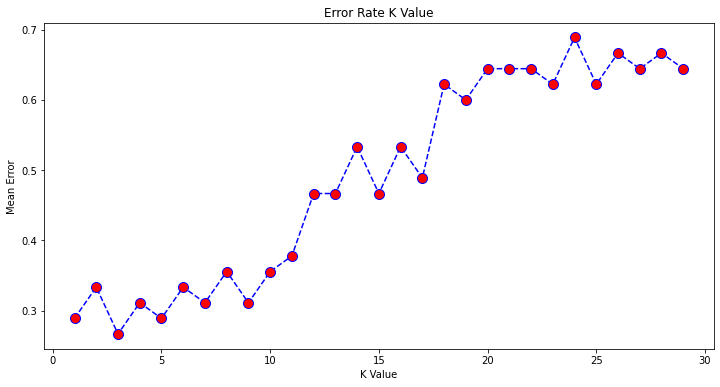

In [278]:
error2 = []

# Calculating error for K values between 1 and 30 for REMOVE DATASET
for i in range(1, 30):
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X_train2, y_train2)
    pred2_i = knn2.predict(X_valid2)
    error2.append(np.mean(pred2_i != y_valid2))
    
# plot the error values against K values using the elbow graph method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error2, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[47 12  0  1]
 [30 24  0  0]
 [ 0  0  5  0]
 [ 2  0  2  0]]
                precision    recall  f1-score   support

       Control       0.59      0.78      0.68        60
    Parkinsons       0.67      0.44      0.53        54
           ALS       0.71      1.00      0.83         5
Cerebral Palsy       0.00      0.00      0.00         4

      accuracy                           0.62       123
     macro avg       0.49      0.56      0.51       123
  weighted avg       0.61      0.62      0.60       123



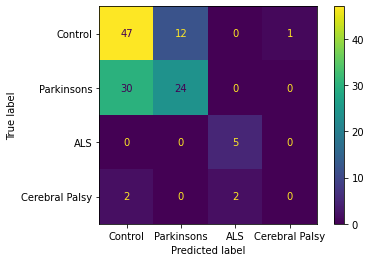

In [279]:
'''Confusion Matrix for Remove Dataset'''
#Evaluating the Algorithm using a confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
y_pred = knn_model.predict(X_test)
target_names = ['Control', 'Parkinsons', 'ALS','Cerebral Palsy']
print(confusion_matrix(y_test, y_pred))
Classification_rep=classification_report(y_test, y_pred,target_names=target_names)
print(Classification_rep)

#Plotting Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=['Control', 'Parkinsons', 'ALS', 'Cerebral Palsy'])  
plt.show() 

Validation Set
                precision    recall  f1-score   support

       Control       0.64      0.82      0.72        60
    Parkinsons       0.82      0.52      0.64        54
           ALS       0.50      1.00      0.67         5
Cerebral Palsy       0.50      0.25      0.33         4

      accuracy                           0.67       123
     macro avg       0.61      0.65      0.59       123
  weighted avg       0.71      0.67      0.67       123



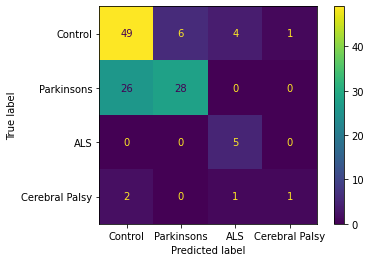

In [280]:
'''Confusion Matrix for Remove Dataset'''
#Evaluating the Algorithm using a confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
y_pred2 = knn_model2.predict(X_test2)
print(f"Validation Set")
Classification_rep2=classification_report(y_test2, y_pred2,target_names=target_names)
print(Classification_rep2)

#Plotting Confusion Matrix for Test set
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn_model2, X_test2, y_test2, display_labels=['Control', 'Parkinsons', 'ALS', 'Cerebral Palsy'])  
plt.show() 



In [281]:
'''Median Dataset'''
#Loglos Evaluation
from sklearn import model_selection
# log loss (closer to 0 is better)
for k in range(2,6,4):
  kfold = model_selection.KFold(n_splits=k, shuffle=True)
  results = model_selection.cross_val_score(knn_model, x, y, cv=kfold, scoring='neg_log_loss')
  print("Logloss: %.3f (%.f)" % (results.mean(), k))

Logloss: -1.090 (2)


In [282]:
'''Remove Dataset'''
#Loglos Evaluation
from sklearn import model_selection
# log loss (closer to 0 is better)
for k in range(2,6,4):
  kfold = model_selection.KFold(n_splits=k, shuffle=True)
  results2 = model_selection.cross_val_score(knn_model2, x2, y2, cv=kfold, scoring='neg_log_loss')
  print("Logloss: %.3f (%.f)" % (results2.mean(), k))

Logloss: -0.857 (2)


In [283]:
'''Median Dataset'''
#Looking at the ROC of our Model
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
print(f"The False Positive Rate prediction is {fpr}")
print(f"The True Positive Rate prediction is {tpr}")
print(f"The Thresholds are {thresholds}")

The False Positive Rate prediction is [0.         0.00847458 0.02542373 0.33050847 1.        ]
The True Positive Rate prediction is [0. 0. 1. 1. 1.]
The Thresholds are [4 3 2 1 0]


In [284]:
'''Remove Dataset'''
#Looking at the ROC of our Model
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pred2, pos_label=2)
print(f"The False Positive Rate prediction is {fpr2}")
print(f"The True Positive Rate prediction is {tpr2}")
print(f"The Thresholds are {thresholds2}")

The False Positive Rate prediction is [0.         0.01694915 0.05932203 0.34745763 1.        ]
The True Positive Rate prediction is [0. 0. 1. 1. 1.]
The Thresholds are [4 3 2 1 0]


# Conclusion

In [285]:
from tabulate import tabulate
print(f"Median Dataset")
print(tabulate([['Train Accuracies (k=1-9)', train_accuracy], ['Test Accuracies (k=1-9)', test_accuracy], ['Logloss', results],["Predictions", y_pred],['Number of Misclassifications',count_misclassified],['Mean Square Error for Training',rmse1],['Mean Square Error for Test',rmse2],['Classification Report',Classification_rep],['False Positive Rate', fpr], ['True positive Rate', tpr], ['Thresholds', thresholds]],headers=['Evaluations', 'Output']))

Median Dataset
Evaluations                     Output
------------------------------  --------------------------------------------------------------------------
Train Accuracies (k=1-9)        [1.         0.87719298 0.85263158 0.82105263 0.8        0.76140351
                                 0.76140351 0.74736842]
Test Accuracies (k=1-9)         [0.76422764 0.69105691 0.72357724 0.65853659 0.67479675 0.66666667
                                 0.6504065  0.61788618]
Logloss                         [-1.18527734 -0.99502799]
Predictions                     [0 1 0 0 0 0 0 0 0 0 2 0 1 0 1 1 1 0 1 0 0 2 1 0 0 0 0 0 2 0 2 0 0 1 0 1 0
                                 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 2 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0
                                 1 1 0 0 0 0 3 0 0 0 1 1 0 0 0 2 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0
                                 0 0 0 0 0 0 0 1 1 2 0 0]
Number of Misclassifications    47
Mean Square Error for Training  0.6515837655350016
Mean S

In [286]:
print(f"Remove Dataset (Trained on Validation Set)")
print(tabulate([['Train Accuracies (k=1-9)', train_accuracy2], ['Test Accuracies (k=1-9)', test_accuracy2], ['Logloss', results2],["Predictions", y_pred2],['Number of Misclassifications',count_misclassified2],['Mean Square Error for Training',rmse_a],['Mean Square Error for Test',rmse_b],['Classification Report',Classification_rep2],['False Positive Rate', fpr2], ['True positive Rate', tpr2], ['Thresholds', thresholds2]],headers=['Evaluations', 'Output']))

Remove Dataset (Trained on Validation Set)
Evaluations                     Output
------------------------------  --------------------------------------------------------------------------
Train Accuracies (k=1-9)        [1.         0.81754386 0.82807018 0.74035088 0.7754386  0.73684211
                                 0.76842105 0.71929825]
Test Accuracies (k=1-9)         [0.75609756 0.65853659 0.6504065  0.68292683 0.6504065  0.70731707
                                 0.65853659 0.67479675]
Logloss                         [-0.86929682 -0.84473471]
Predictions                     [0 0 0 1 0 1 0 1 0 0 2 0 1 0 0 2 0 1 1 0 0 2 0 0 2 0 0 0 2 0 2 1 0 0 0 1 0
                                 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 2 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
                                 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 3 1 0 0 0 1 1 0 0 0 3 0 1 1 0 0 0 0 0 2 0 2
                                 0 1 0 0 0 1 0 0 1 2 1 0]
Number of Misclassifications    40
Mean Square Error for Trainin